# Project 3 - Butterfly Image Classification

## Introduction 

In this project, I will use a convolutional neural network model to classify butterfly images. Image classification is a deep learning problem with many applications, in this case, butterfly identification. The convolutional neural network is considered a supervised method because it uses known labels to train the model. 

My specific goals are to implement :
- CNN basic model
- ResNet50 pre-trained CNN model
- Kmeans clustering model for comparison 


The butterfly [image dataset](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) is sourced from kaggle. It originally included a training and test set of butterfly images, each corresponding to a single classification. The original training set alone included 6500 images of butterflies and an excel file linking image and classification category. For the sake of space on my computer, I completely removed the test set and I will then split the training set into a train/test and this way I have labels to assess the effectiveness of my models.

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import train_test_split


# Cleaning and EDA

First let's look at the size of our dataset. We'll import the excel information matching image to its class.

In [86]:
data = pd.read_csv("Training_set.csv")

In [87]:
data.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


We should have 6499 entries in the dataset corresponding to 6499 images.

In [88]:
size = len(data)
size

6499

Now let's take a look at the unique classes. We can see below that we have 75 classes and they are all species of butterflies.

In [89]:
#what classes do we have
classes= data['label'].unique()
print("Class count = ", len(classes))
print("classes are: \n", classes)

Class count =  75
classes are: 
 ['SOUTHERN DOGFACE' 'ADONIS' 'BROWN SIPROETA' 'MONARCH'
 'GREEN CELLED CATTLEHEART' 'CAIRNS BIRDWING' 'EASTERN DAPPLE WHITE'
 'RED POSTMAN' 'MANGROVE SKIPPER' 'BLACK HAIRSTREAK' 'CABBAGE WHITE'
 'RED ADMIRAL' 'PAINTED LADY' 'PAPER KITE' 'SOOTYWING' 'PINE WHITE'
 'PEACOCK' 'CHECQUERED SKIPPER' 'JULIA' 'COMMON WOOD-NYMPH' 'BLUE MORPHO'
 'CLOUDED SULPHUR' 'STRAITED QUEEN' 'ORANGE OAKLEAF' 'PURPLISH COPPER'
 'ATALA' 'IPHICLUS SISTER' 'DANAID EGGFLY' 'LARGE MARBLE'
 'PIPEVINE SWALLOW' 'BLUE SPOTTED CROW' 'RED CRACKER' 'QUESTION MARK'
 'CRIMSON PATCH' 'BANDED PEACOCK' 'SCARCE SWALLOW' 'COPPER TAIL'
 'GREAT JAY' 'INDRA SWALLOW' 'VICEROY' 'MALACHITE' 'APPOLLO'
 'TWO BARRED FLASHER' 'MOURNING CLOAK' 'TROPICAL LEAFWING' 'POPINJAY'
 'ORANGE TIP' 'GOLD BANDED' 'BECKERS WHITE' 'RED SPOTTED PURPLE'
 'MILBERTS TORTOISESHELL' 'SILVER SPOT SKIPPER' 'AMERICAN SNOOT' 'AN 88'
 'ULYSES' 'COMMON BANDED AWL' 'CRECENT' 'METALMARK' 'SLEEPY ORANGE'
 'PURPLE HAIRSTREAK' 'ELBOWED 

Now let's look at the distribution of these classes to see if there is any classes that we might want to drop due to insufficient data. 

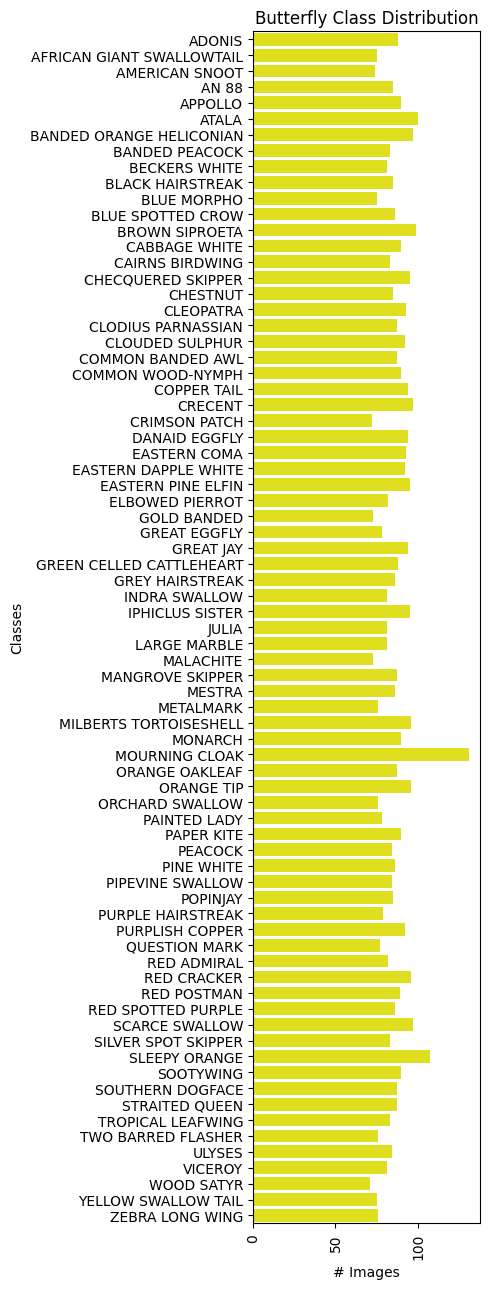

In [90]:
class_counts = data['label'].value_counts().sort_index()

plt.figure(figsize=(5, 13))
sns.barplot(y=class_counts.index, x=class_counts.values, color='yellow')
plt.title('Butterfly Class Distribution')
plt.xlabel('# Images')
plt.ylabel('Classes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [91]:
print("Three classes with most samples are: \n", class_counts.sort_values(ascending=False)[:3], "\n")
print("Three classes with least samples are: \n", class_counts.sort_values()[:3])

Three classes with most samples are: 
 label
MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
Name: count, dtype: int64 

Three classes with least samples are: 
 label
WOOD SATYR       71
CRIMSON PATCH    72
MALACHITE        73
Name: count, dtype: int64


We can see here that the sample size for all classes ranges from 71-131. This seems reasonable and unlikely to skew the data. I will consider changing this later on if I end up having problems but for now I am going to keep everything as is. 

Now let's take a look at some of the images. We see below that the images are relatively close-up shots wth butterfly wings in various arrangements. Photos seem to be well-centered and clearly show the full form of the butterfly without cutting it off. 

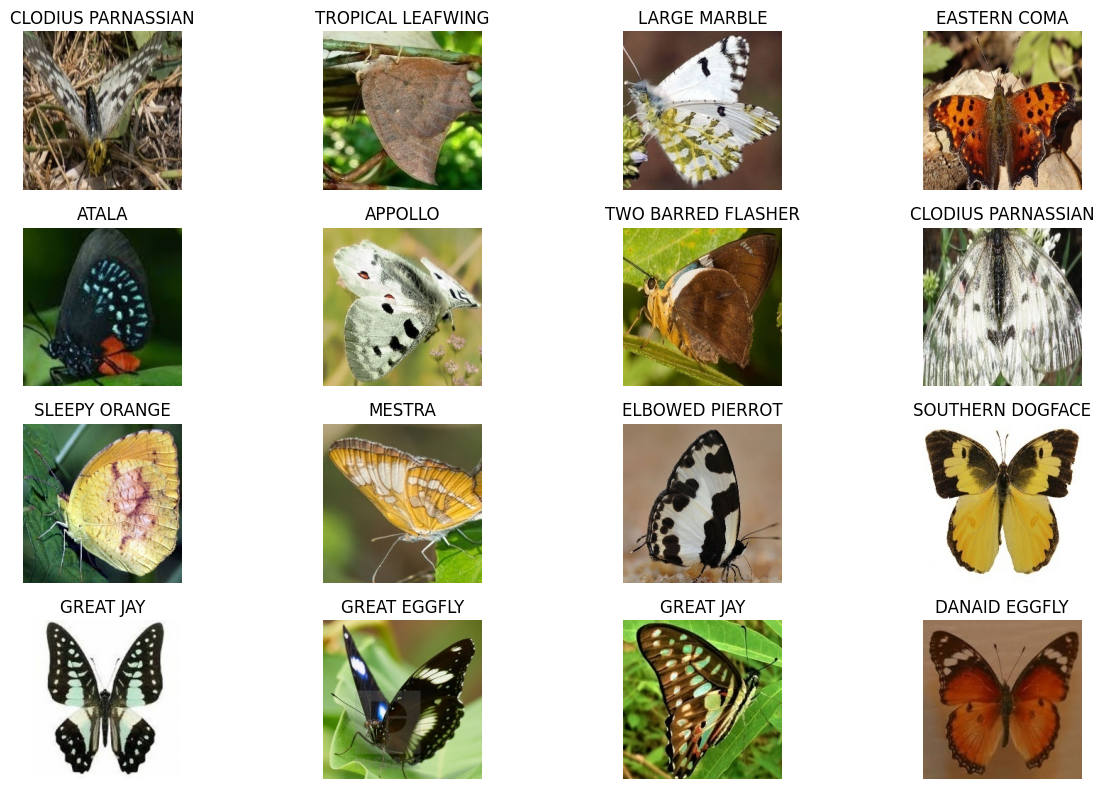

In [92]:
image_dir = "train"

fig, axes = plt.subplots(4, 4, figsize=(13, 8))
sample_images = data.sample(16, random_state=2)

for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['filename'])
    img = load_img(img_path)
    ax = axes[i // 4, i % 4]
    ax.imshow(img)
    ax.set_title(f"{row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()


Note - I had noticed that there is a species labelled "QUESTION MARK". I didn't know if this was a label for unknown but upon googling and checking other images, I determined that this is a vaild butterfly class. 

Note - I noticed in the above image of the Great EggFly (row 4, col 2) that there is a slight watermark. I assume that there are some other images that may also have a watermark. This will be something to keep in mind later on. 

In [93]:
#what are the dimensions of each image?

img = plt.imread("train/Image_1.jpg")
height, width = img.shape[:2]  # For grayscale or RGB images
print(f"Image_1 dimensions: {width}x{height}")

img2 = plt.imread("train/Image_10.jpg")
height, width = img2.shape[:2]  # For grayscale or RGB images
print(f"Image_10 dimensions: {width}x{height}")

img3 = plt.imread("train/Image_1000.jpg")
height, width = img3.shape[:2]  # For grayscale or RGB images
print(f"Image_1000 dimensions: {width}x{height}")

Image_1 dimensions: 224x224
Image_10 dimensions: 224x224
Image_1000 dimensions: 224x224


It appears that 224x224 is the standard size of all images. That seems like a reasonable size but I did notice a lot of examples downsize to 150 x 150 so I will do that to keep this running fast and to standardize size if any images happen to vary. 

Finally, let's check if any data is missing. We see that no image paths or labels are missing. 

In [94]:
print(data[data.isna().any(axis=1)])

print("\n No data missing")



Empty DataFrame
Columns: [filename, label]
Index: []

 No data missing


Now let's prep the data into a dataset. Right now, I just have a folder with images so I need to split them into two groups for train and test. Then I need to load them into a dataset that I can input into a model. 

In [95]:
train, test = train_test_split(data, test_size=0.19, random_state=42)

print("Length of train:", len(train))
print("Length of test:", len(test))

Length of train: 5264
Length of test: 1235


Now I am going to use the ImageDataGenerator tool combined with flow_from_dataframe in Tensorflow to load images from my directory and into batches. ImageDataGenerator is a class in TensorFlow that helps to load and preprocess images. I decided to use it here since I read that it commonly used for image classification. Here I use it to load images from a directory and normalize pixels but it can also augment images by rotating, zooming, flipping, etc. I do this here to add some "variation" into my data to avoid overfitting and hopefully improve performance on unseen data. I combined this with flow_from_dataframe since all my image information and labels are currently contained in a dataframe. I used the tutorial from [here](https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c) to learn how to implement these. 

We see that we end up with two objects that are equal in size and expected class of our train/test sizes.

In [ ]:
#get data gen objects and normalize pixel values

#augmentations create variation in the data to avoid overfitting, improves generalization 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)


#get images into their own data set 
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    subset="training",
    target_size=(150, 150),
    batch_size=28, #must be a # that can divide evenly into total size of train dataset
    class_mode='categorical', #bc multiple classes of butterfly 
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=image_dir,
    x_col='filename',   
    y_col='label',
    subset="training",
    target_size=(150, 150),
    batch_size=19, #must be a # that can divide evenly into total size of test dataset
    class_mode='categorical', #bc multiple classes of butterfly 
    shuffe = False
)


Found 5264 validated image filenames belonging to 75 classes.
Found 1235 validated image filenames belonging to 75 classes.


Summary of EDA and cleaning - 

Initial cleaning was done randomly to reduce the size of the dataset for personal computer reasons. Then I looked at class distribution, image size, and missing values and decided that no additional data needed to be dropped or modified. I also took a quick look at the images to get an idea of what kind of photos we had. Overall, this dataset was very well prepared so there was not much cleaning work to be done on the images or label data. 

The next task was to put everything into an object that can be passed into the model. I used ImageDataGenerator combined with flow_from_dataframe to generate both train and test data, as described above.

## Modelling 

### Model Building / Model Choice

#### CNN

The first model I chose to use was the Convolutional Neural Network (CNN). This model is well-suited for image classification because it is not fully connected at all layers - this would be get way too computationally intensive with large images. A convolutional neural network consists of convolutional layers where images are broken down into components with increasing fields of view. This is followed by a pooling layer (usually max pool or average pool) and then finally a reduced data set is fed into a fully connected layer where we receive our output. 

Now I will build the model and add in the layers. I am using Sequential from Keras, which groups a linear stack of layers into a model. Then I will add the layers in. For example, the first layer is a Conv2D layer, where I apply 32 filters of size 3x3 to the image, resulting in 32 outputs. I use relu activation and then input the shape of the image. Then the following max pooling layer reduces dimensions of the image. Then another Conv2D layer with more filters and so on. I got these initial numbers from [this tutorial](https://www.kaggle.com/code/anandhuh/image-classification-using-cnn-for-beginners).

In [123]:
#build the cnn model 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

cnn = Sequential()

#add layers
cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(128, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))


#now let's what our model looks like at this point
cnn.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

We see above that each layer is a 3D tensor where the first two digits correspond to width and height and the third is channels. We specifically increased our channels so this makes sense. And we can see the effect of maxpooling reducing the height and width in half each time, since we used (2,2). 

Now we need to feed the output of the last layer above into a dense layer to make our classification. Dense layers accept 1D input and we currently have a 3D tensor so we need to use the Flatten() command to reformat. Then we can feed into a dense layer. We use Dense layer with 512 neurons based on hyperparameter tuning seen below (keep reading). Then we add a dense layer with 75 outputs to correspond to our 75 butterfly classes.

In [ ]:
cnn.add(Flatten())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dense(75, activation = 'softmax'))

In [125]:
cnn.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,072,139 (72.75 MB)

 Trainable params: 19,072,139 (72.75 MB)

 Non-trainable params: 0 (0.00 B)

Now I'm going to show the hyperparameter tuning that led me to pick the channels in my first dense layer. Below I show options for 32, 128, and 512 neurons in the dense layer. I just test across 5 epochs for the sake of time and to get an idea of how this channel selection affects the model performance. 

In [105]:
#Now let's try out at a couple different options for the first dense layer's input. I'm just going to use 5 epochs for the sake of time. 


cnn32 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(75, activation = 'softmax')
])

cnn128 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(75, activation = 'softmax')
])

cnn512 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(75, activation = 'softmax')
])


cnn32.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

output32 = cnn32.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator   #validate with test data 
)

cnn128.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
output128 = cnn128.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator   #validate with test data 
)

cnn512.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
output512 = cnn512.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator   #validate with test data 
)


Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 51s 262ms/step - accuracy: 0.0195 - loss: 4.3045 - val_accuracy: 0.0559 - val_loss: 4.0762
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 284ms/step - accuracy: 0.0586 - loss: 4.0080 - val_accuracy: 0.1085 - val_loss: 3.6627
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 52s 276ms/step - accuracy: 0.0992 - loss: 3.6131 - val_accuracy: 0.1814 - val_loss: 3.1653
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 279ms/step - accuracy: 0.1674 - loss: 3.1841 - val_accuracy: 0.2081 - val_loss: 3.0019
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 52s 278ms/step - accuracy: 0.2220 - loss: 2.9119 - val_accuracy: 0.3077 - val_loss: 2.5645
Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 59s 307ms/step - accuracy: 0.0313 - loss: 4.2194 - val_accuracy: 0.1344 - val_loss: 3.4326
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 296ms/step - accuracy: 0.1482 - loss: 3.3404 - val_accuracy: 0.2219 - val_loss: 2.9859
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 295ms/step - accuracy: 0.2356 - loss: 2.8775 - 

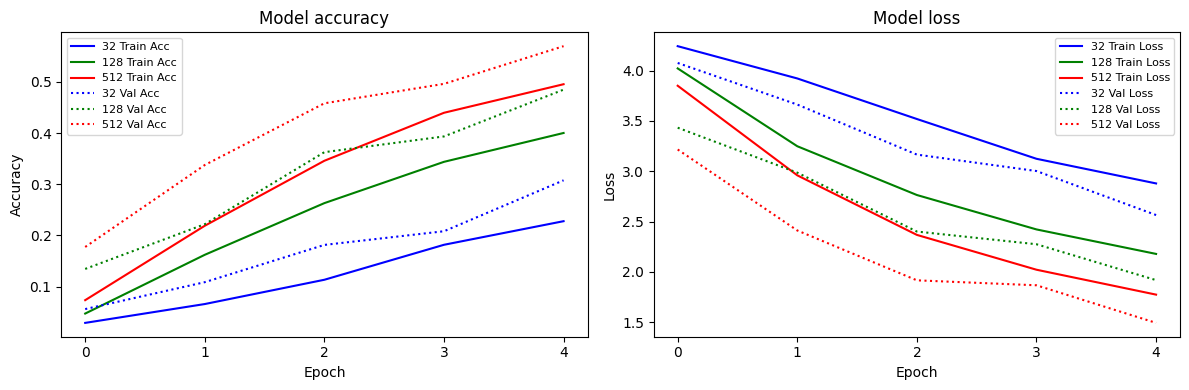

In [128]:
#now let's plot the performance of each model
train_acc32 = output32.history['accuracy']
val_acc32 = output32.history["val_accuracy"]
train_acc128 = output128.history['accuracy']
val_acc128 = output128.history["val_accuracy"]
train_acc512 = output512.history['accuracy']
val_acc512 = output512.history["val_accuracy"]

train_loss32 = output32.history["loss"]
val_loss32 = output32.history["val_loss"]
train_loss128 = output128.history["loss"]
val_loss128 = output128.history["val_loss"]
train_loss512 = output512.history["loss"]
val_loss512 = output512.history["val_loss"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc32, color = "blue", label = "32 Train Acc")
plt.plot(train_acc128, color = "green", label = "128 Train Acc")
plt.plot(train_acc512, color = "red", label = "512 Train Acc")
plt.plot(val_acc32, color = "blue", linestyle = "dotted", label = "32 Val Acc")
plt.plot(val_acc128, color = "green", linestyle = "dotted", label = "128 Val Acc")
plt.plot(val_acc512, color = "red", linestyle = "dotted", label = "512 Val Acc")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks([0,1,2,3,4])
plt.legend(loc='upper left', fontsize=8)

plt.subplot(1, 2, 2)
plt.plot(train_loss32, color = "blue", label = "32 Train Loss")
plt.plot(train_loss128, color = "green", label = "128 Train Loss")
plt.plot(train_loss512, color = "red", label = "512 Train Loss")
plt.plot(val_loss32, color = "blue", linestyle = "dotted", label = "32 Val Loss")
plt.plot(val_loss128, color = "green", linestyle = "dotted", label = "128 Val Loss")
plt.plot(val_loss512, color = "red", linestyle = "dotted", label = "512 Val Loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right',fontsize = 8)
plt.xticks([0,1,2,3,4])

plt.tight_layout()
plt.show()

Based on these graphs above, we can see that increasing the number of neurons in the first layer yields better accuracy and loss metrics. Based on this information, I chose 512 for the final model. Now let's run it. 

We can also observe in the graph above, that accuracy and loss metrics improve over multiple epochs. I will use this insight when I train the final model below. 

### Modelling: Compile and Train 

Now we have built the structure of the model with our chosen hyperparameters. Now let's compile and train it and see how the metrics change over each epoch. 

In [126]:
#compile, used common hyperparameters from tutorial mentioned above
cnn.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

performance = cnn.fit(
    train_generator,
    epochs=25, 
    validation_data=test_generator   #validate with test data 
)


Epoch 1/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 72s 375ms/step - accuracy: 0.0462 - loss: 4.1049 - val_accuracy: 0.1514 - val_loss: 3.4895
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.1889 - loss: 3.1208 - val_accuracy: 0.2842 - val_loss: 2.6397
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 351ms/step - accuracy: 0.2909 - loss: 2.6526 - val_accuracy: 0.3927 - val_loss: 2.1931
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.3691 - loss: 2.2697 - val_accuracy: 0.4802 - val_loss: 1.8623
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 349ms/step - accuracy: 0.4409 - loss: 1.9752 - val_accuracy: 0.5255 - val_loss: 1.7552
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 372ms/step - accuracy: 0.5043 - loss: 1.7014 - val_accuracy: 0.5198 - val_loss: 1.7454
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 354ms/step - accuracy: 0.5463 - loss: 1.5960 - val_accuracy: 0.6121 - val_loss: 1.3152
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.5653 - loss: 1

From the output of the model training above, we can see that at the end of 25 epochs our training accuracy is about 80% and our test accuracy is about 73%. 

Now let's look at these performance metrics across different epochs to see if there is an ideal number of epochs. 

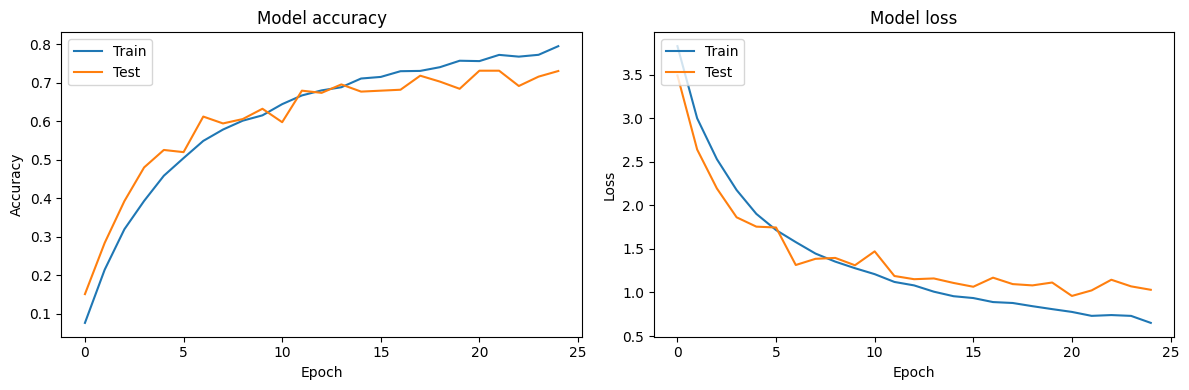

In [127]:
epochs = performance.epoch
train_acc = performance.history['accuracy']
val_acc = performance.history["val_accuracy"]

train_loss = performance.history["loss"]
val_loss = performance.history["val_loss"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


Looking at the graphs above, we can see a steady rise in model accuracy in both test and train until about epoch 15 when test starts to level out and train grows at a smaller rate. The same can be observed with the loss curve, the lines flatten out around epoch 15. It appears that we hit a good performance level around epoch 15 and would not want to go much farther to avoid unncessary complication. 

Now let's look at a single batch below to see how our predictions look. Since we're just looking at a single batch, the accuracy scores may vary. We see here that our accuracy score for this batch is about 78%.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


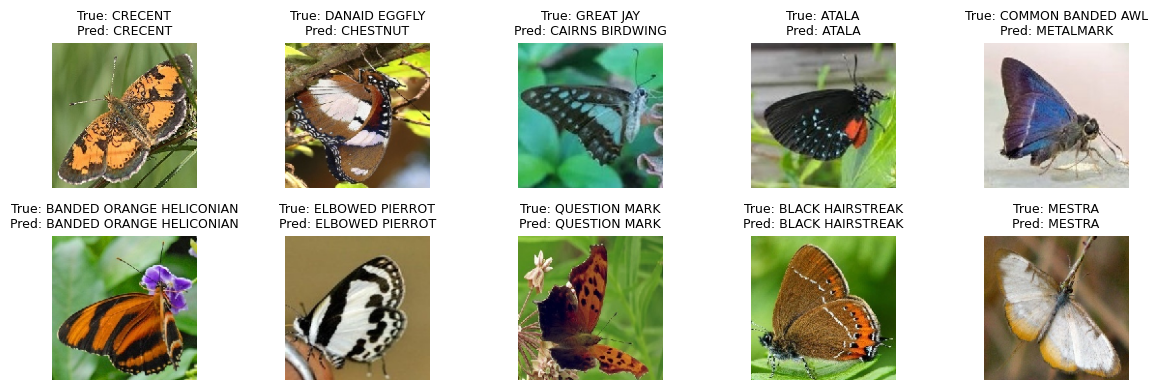

Accuracy score for this batch is:  0.7894736842105263


In [255]:
sample_imgs, sample_labels =next(test_generator) #get batch of images and labels 
#these are both of shape images, classes so we need to take just the max class 
pred_labels = np.argmax(cnn.predict(sample_imgs), axis=1)
true_labels = np.argmax(sample_labels, axis=1)

class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize = 9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(sample_imgs, true_labels, pred_labels, class_names, num_images=10)

from sklearn.metrics import accuracy_score
acc_sc = accuracy_score(true_labels, pred_labels)
print("Accuracy score for this batch is: ", acc_sc)

Now let's look at performance metrics across all test samples. First, we need to get the list of true y values which is stored in test_generator and then use those images to predict test values. As expected our prediction is about 72% accurate

In [472]:
true_labels_list = []
predicted_labels_list = []

# move through the test generator batch by batch 
for images, labels in test_generator:
    #true labels from excel sheet 
    true_labels_list.append(labels) 

    # predictions for the current batch
    batch_predictions = cnn.predict(images)

    # Convert probabilities to class indices (for multi-class classification)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)

    # Store the predictions
    predicted_labels_list.append(batch_predicted_labels)

    #stops after one round through
    if test_generator.batch_index == 0:
        break


# Combine all true labels and predicted labels into single arrays
true_labels = np.argmax(np.concatenate(true_labels_list, axis=0),axis=1)
predicted_labels = np.concatenate(predicted_labels_list, axis=0)

print("Overall accuracy score is: ", accuracy_score(true_labels,predicted_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)

Text(120.72222222222221, 0.5, 'True Labels')

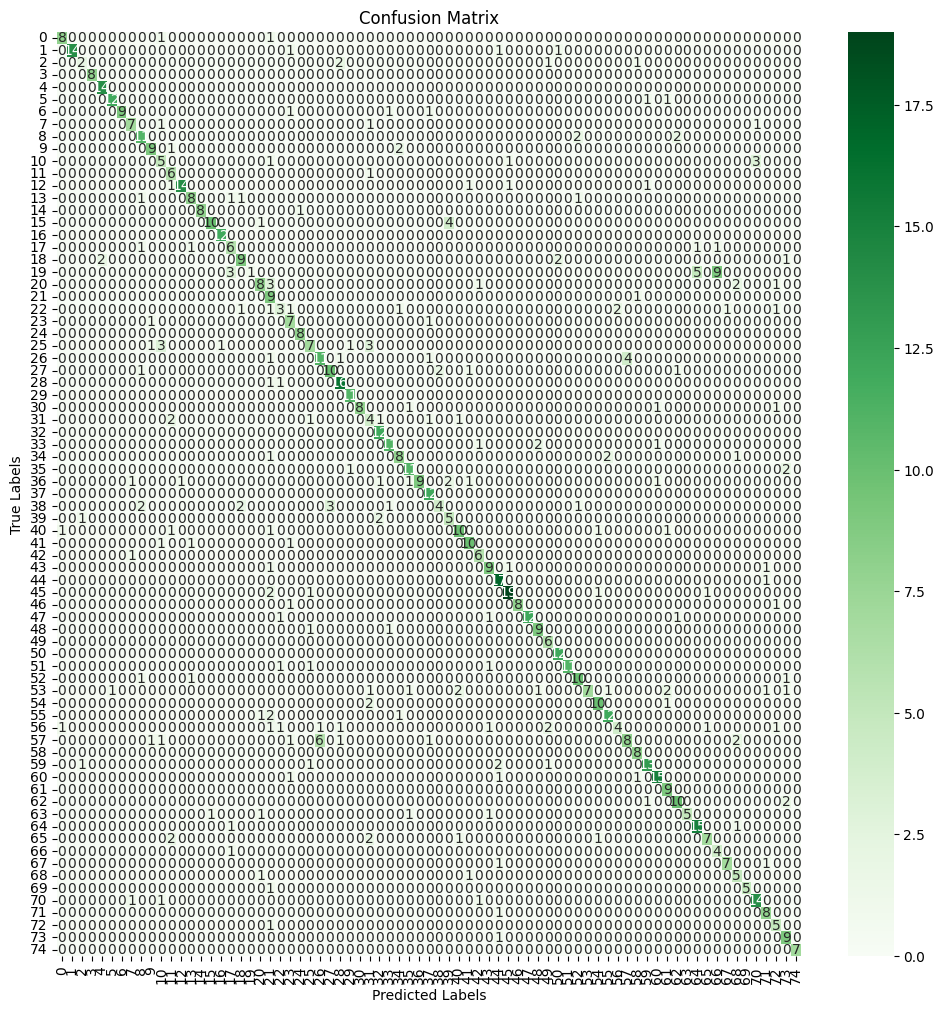

In [ ]:
plt.figure(figsize=(12, 12))  # Increase figure size

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

The confusion matrix shows us that the misidentifications are relatively spread out across species. A couple species however do have high misidentification rates. For example, species 19 is commonly confused with species 66. Let's take a look at those. 

In [296]:
names_dict = test_generator.class_indices
names_dict_reversed = {v:k for k,v in names_dict.items()}
print("Class 19 is ", names_dict_reversed[19])
print("Class 66 is ", names_dict_reversed[66])

Class 19 is  CLOUDED SULPHUR
Class 66 is  SOUTHERN DOGFACE


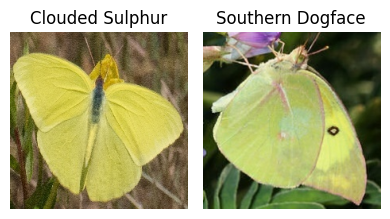

In [424]:
img_CS = load_img("train/Image_25.jpg")
img_SD = load_img("train/Image_1.jpg")
fig, axes = plt.subplots(1, 2, figsize=(4, 8))

# Display the first image
axes[0].imshow(img_CS)
axes[0].axis('off')  # Turn off axes for a cleaner look
axes[0].set_title("Clouded Sulphur")  # Add a title if desired

# Display the second image
axes[1].imshow(img_SD)
axes[1].axis('off')  # Turn off axes for a cleaner look
axes[1].set_title("Southern Dogface")  # Add a title if desired

# Show the plot
plt.tight_layout()  # Adjust spacing between images
plt.show()

We can see here that these two species look remarkably similar so it's not suprising that the model might confuse the two of them. 

Let's look at generate some final performance metrics for this model that we will examine at the end.

In [474]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=names_dict_reversed.values(), output_dict=True)

Overall, I am happy with the performance of this CNN model. It has a final accuracy of 75% and relatively even performance across categories (seen in the report above). The misidentifications appear to be reasonable (species look alike to the human eye) and potentially could be solved by adding more layers and neurons to each layer, since this is a relatively simple model. 

#### KMeans Clustering

Now, I am going to play around KMeans clustering to group the images. I don't expect this to do well but I wanted a baseline comparison before doing another CNN. It should be noted that kmeans clustering is unsupervised, while the other two models are supervised. 

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.cluster import MiniBatchKMeans

#load images as arrays to work with the kmeans model 
def load_images(folder):
    img_arrays = []
    for filename in data["filename"]:
        img = load_img(os.path.join(folder, filename), target_size=(150 , 150))  # resize to same size as before 
        img_array = img_to_array(img)  # convert to array
        img_array = img_array.flatten() / 255.0  # flatten from 3d to 1d and normalize
        img_arrays.append(img_array)
    return np.array(img_arrays)

array_data = load_images("train")

# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = 75)
# Fitting the model to training set
kmeans.fit(array_data)



MiniBatchKMeans(n_clusters=75)

Basic model is made. Let's fit and map labels. 

In [ ]:
from scipy.optimize import linear_sum_assignment

kmeans.predict(array_data)

#get predicted values 
y_pred = kmeans.labels_

#turn string labels into numbers to get true values 
y_true = data["label"]
string_to_number = {string: idx for idx, string in enumerate(np.unique(y_true))}
y_true = [string_to_number[string] for string in y_true]

cm2 = confusion_matrix(y_true, y_pred)

In [ ]:
def remap_labels(y_true, y_pred):
    """
    Remaps a categorical labeling (such as one predicted by a clustering algorithm) to
    match the labels used by another similar labeling.

    Source: https://docs.neurodata.io/notebooks/pedigo/graspologic/clustering/2020/10/12/remapping-labels.html
    """
    confusion_mat = confusion_matrix(y_true, y_pred)
    row_inds, col_inds = linear_sum_assignment(confusion_mat, maximize=True) #this basically lines up the class numbers after looking at the cm
    label_map = dict(zip(col_inds, row_inds))
    remapped_y_pred = np.vectorize(label_map.get)(y_pred)
    return remapped_y_pred


In [370]:
y_remapped = remap_labels(y_true, y_pred)

print(accuracy_score(y_true, y_remapped))


0.11294045237728881


After matching labels, we observe a low performance from this model. This makes sense, since KMeans is not necessarily going to be able to pick apart the multiple scales of details of the butterfly images in the same way a CNN does. 

Below, is the confusion matrix. We can see that the labels are aligned as best as possible, but there is still not a good performance. 

Text(120.72222222222221, 0.5, 'True Labels')

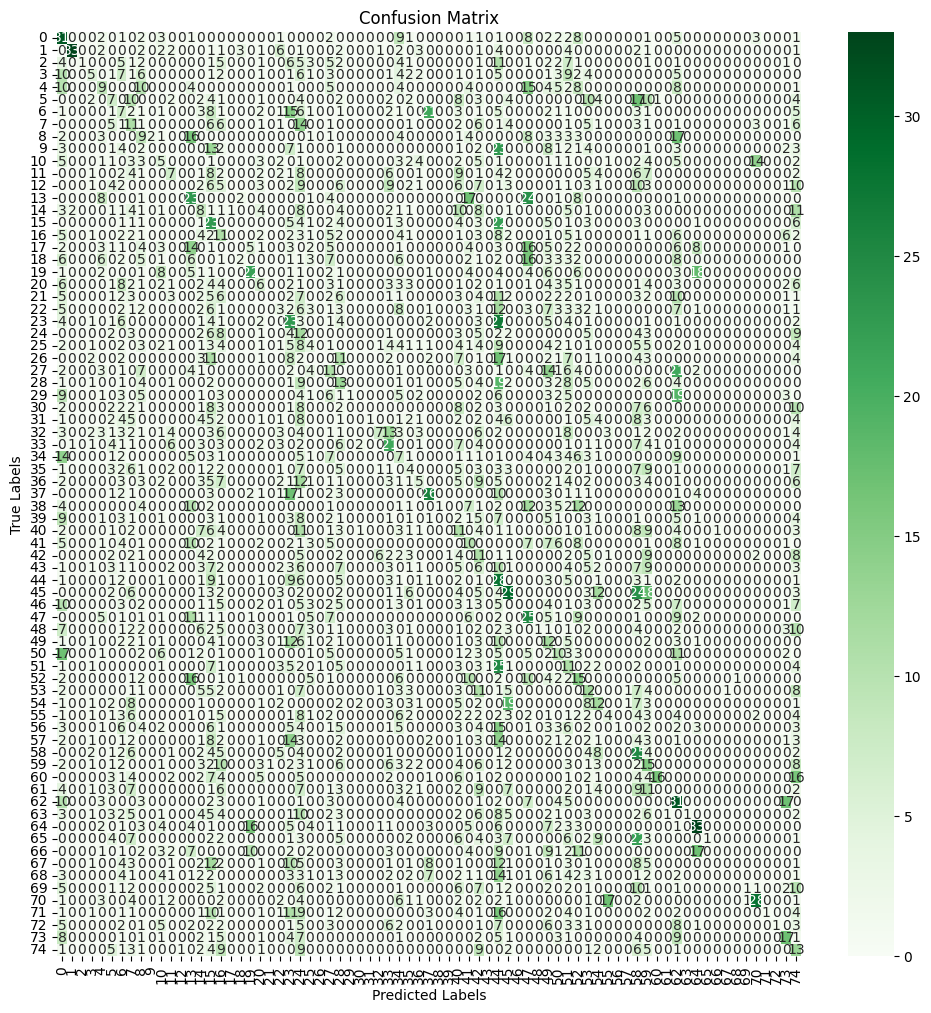

In [ ]:
#plot confusion matrix
plt.figure(figsize=(12, 12)) 
cm3 = confusion_matrix(y_true, y_remapped)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [378]:
print(classification_report(y_true, y_remapped))

              precision    recall  f1-score   support

           0       0.12      0.35      0.18        88
           1       0.92      0.44      0.59        75
           2       1.00      0.01      0.03        74
           3       0.16      0.06      0.09        85
           4       0.15      0.10      0.12        90
           5       0.09      0.07      0.08       100
           6       0.05      0.07      0.06        97
           7       0.08      0.13      0.10        83
           8       0.08      0.11      0.09        81
           9       0.00      0.00      0.00        85
          10       0.08      0.07      0.07        75
          11       0.17      0.08      0.11        86
          12       0.00      0.00      0.00        99
          13       0.16      0.26      0.20        90
          14       0.08      0.10      0.09        83
          15       0.08      0.24      0.12        95
          16       0.06      0.13      0.08        85
          17       0.00    

C:\Users\Nicole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Nicole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Nicole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Overall, the Kmeans clustering approach was unsuccessful, yielding a final accuracy of .11 and pretty dismal scores across all classes. But this provides a good benchmark for comparing to the two CNN models and reinforces their utility.

#### ResNet50 Model

For my last model, I will use the ResNet50 Model. This model is a pretrained convolutional neural network designed to solve the problem of vanishing gradients. It is a common choice for image classification, especially for a dataset of this size - not too big and not too small. As the name suggests, its architecture includes 50 layers. The model is "pretrained" which means it has been trained on a large dataset and my "training" here is just to fine tune it to the images I am working with. Since my classification problem involves distinguishing species of butterflies, rather than large differences (for example distinguising butterfly vs. human vs. tree), I will do some additional training in the upper layers and add some final layers to make sure I get the number of outputs that I want. 

I make minimal adjustments including:
- training the top 20% of layers, keeping the prior ones untrainable
- 2 Dense layers like in the previous CNN, I do use a smaller number of neurons in the first layer just for the sake of time (256 vs 512)
- compile with the same hyperparameters as before: Adam, categorical crossentropy, accuracy

In [437]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Input

#set up base model 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

#need to include some layers, else the model accuracy doesn't get about 10%
num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))
for layer in base_model.layers[:num_layers_to_train] :
    layer.trainable = False


In [438]:
#add custom layers on top of base model, very similar to before, flatten and then go through 2 dense layers yielding a final layer of 75
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x) #to get our 75 classes 

model = Model(inputs=base_model.input, outputs=predictions)

# compile the model with similar hyperparameters as before 
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_135"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_29[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 36,714,443 (140.05 MB)

 Trainable params: 36,451,659 (139.05 MB)

 Non-trainable params: 262,784 (1.00 MB)

Now that we have our baseline model plus added custom layers, let's train it. I will use the same data as before to train and test. I am using less epochs here for the sake of time. This model includes many more layers than the previous CNN so I'm not concerned about needing to use a ton of epochs. 10 should suffice to get an idea of the general pattern. 

In [439]:
history = model.fit(
    train_generator,  
    epochs=10,
    validation_data=test_generator,  
    verbose=1
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.1031 - loss: 8.8595 - val_accuracy: 0.0785 - val_loss: 7.8516
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.4551 - loss: 5.5320 - val_accuracy: 0.4551 - val_loss: 5.0871
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6613 - loss: 3.8278 - val_accuracy: 0.6923 - val_loss: 3.3778
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.7454 - loss: 2.9713 - val_accuracy: 0.7644 - val_loss: 2.7397
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.8214 - loss: 2.3129 - val_accuracy: 0.7838 - val_loss: 2.4033
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.8315 - loss: 1.9760 - val_accuracy: 0.7700 - val_loss: 2.1405
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8561 - loss: 1.6951 - val_accuracy: 0.7919 - val_loss: 1.9985
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.8863 - loss: 1.4360 - val_accu

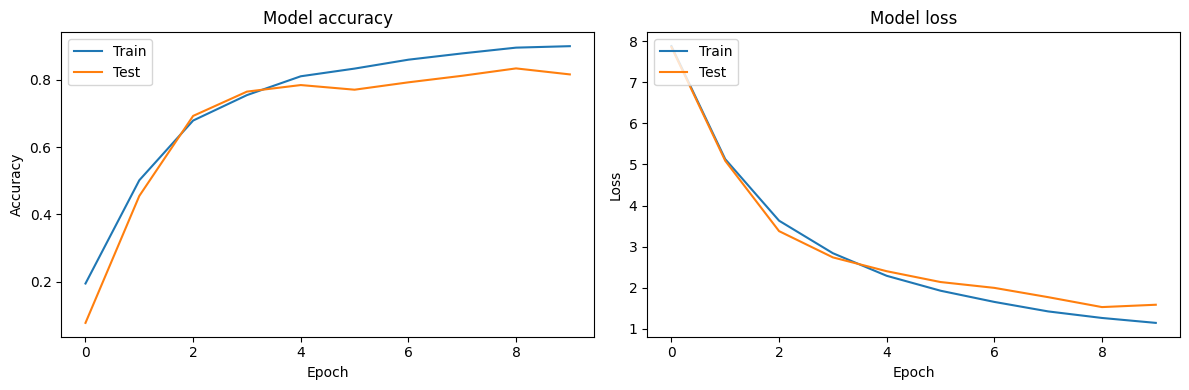

In [440]:
train_acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


Looking at the results above, we see that we maybe didn't need to train the model quite so far. For the sake of not re-running it, I will keep it as is since we do not appear to be overfitting. However it should be mentioned that anything from 5-10 epochs would be suitable here since that is where the scores level off in both figures. 

In [508]:
true_labels_list = []
predicted_labels_list = []

# move through the test generator batch by batch 
for images, labels in test_generator:
    #true labels from excel sheet 
    true_labels_list.append(labels) 

    # predictions for the current batch
    batch_predictions = model.predict(images)

    # Convert probabilities to class indices (for multi-class classification)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)

    # Store the predictions
    predicted_labels_list.append(batch_predicted_labels)

    #stops after one round through
    if test_generator.batch_index == 0:
        break


# Combine all true labels and predicted labels into single arrays
true_labels = np.argmax(np.concatenate(true_labels_list, axis=0),axis=1)
predicted_labels = np.concatenate(predicted_labels_list, axis=0)

print("Overall accuracy score is: ", accuracy_score(true_labels,predicted_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

This model is performing well with an accuracy score of 86% percent.

In [516]:
acc_score_res_net = accuracy_score(true_labels,predicted_labels)
print(acc_score_res_net)

0.8615384615384616


<Axes: >

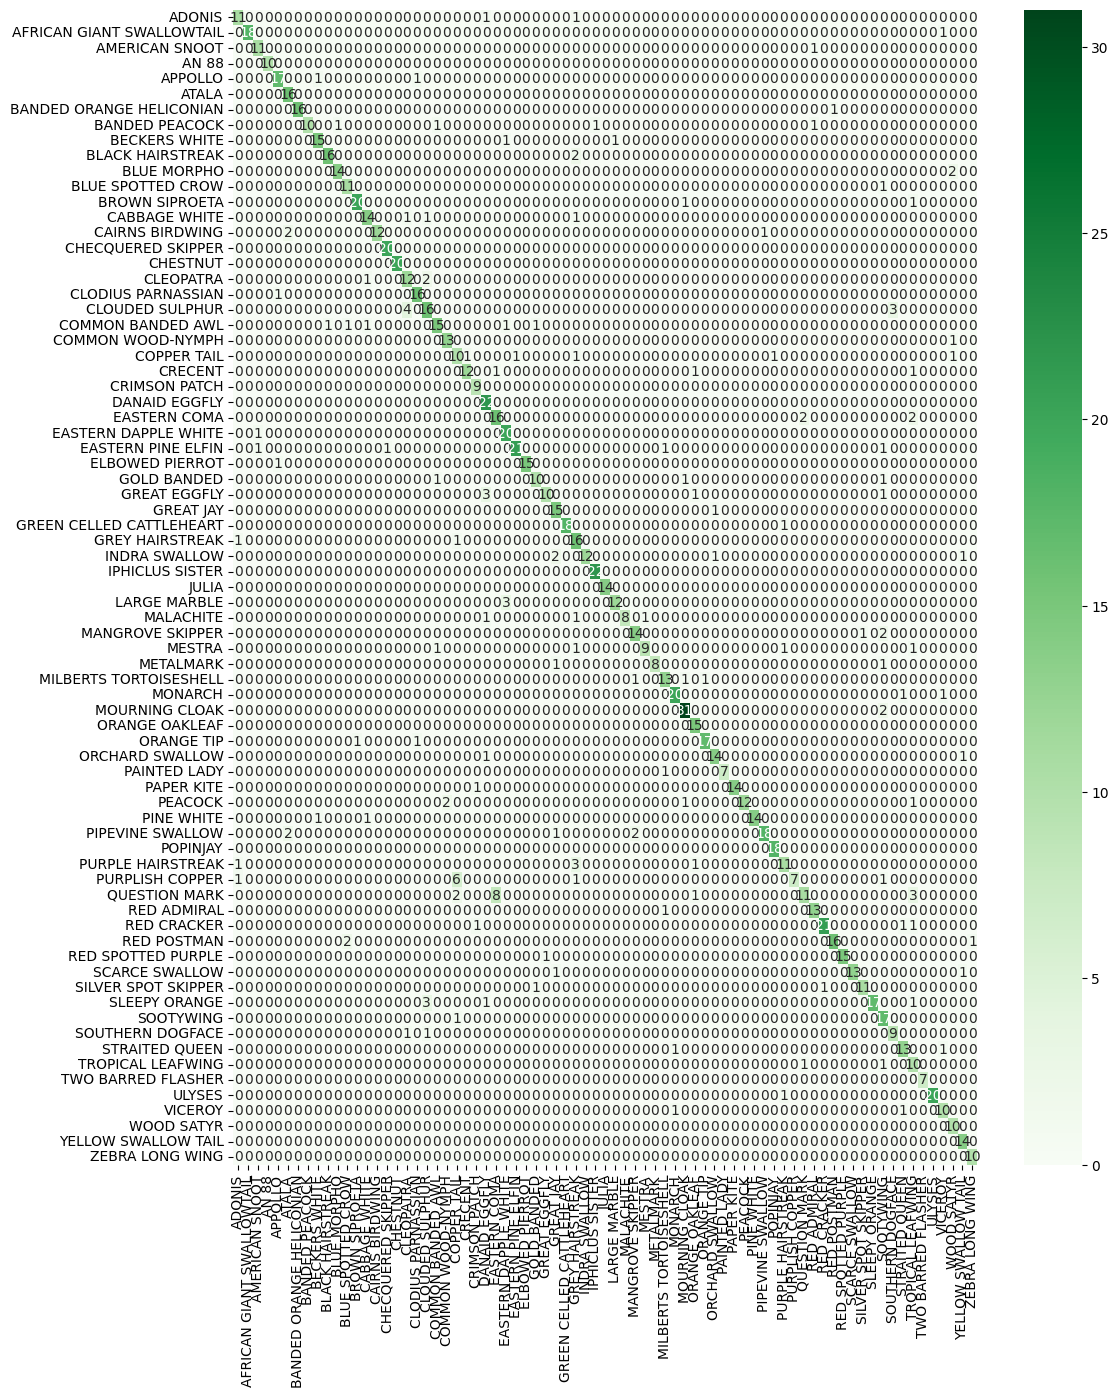

In [517]:
cm4 = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(12, 15))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Greens', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())


We see here the misidentifications are mostly spread out with a few minor exceptions. For example, Question Marks are commonly confused with Eastern Commas. Let's take a look and see why. 

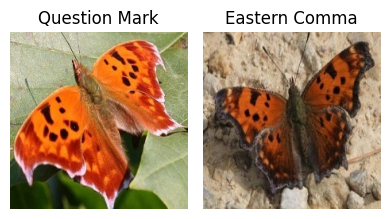

In [513]:
img_qm = load_img("train/Image_46.jpg")
img_ec = load_img("train/Image_187.jpg")

fig, axes = plt.subplots(1, 2, figsize=(4, 8))

axes[0].imshow(img_qm)
axes[0].axis('off')  
axes[0].set_title("Question Mark")  

axes[1].imshow(img_ec)
axes[1].axis('off')  
axes[1].set_title("Eastern Comma")  


plt.tight_layout()  
plt.show()

We can see that these two species are visually quite similar, so it makes sense that the model would have trouble differentiating these two.

Now let's generate the final scores and compare to the first CNN. 

In [521]:
report_resnet = classification_report(true_labels, predicted_labels,target_names=names_dict_reversed.values(), output_dict=True)

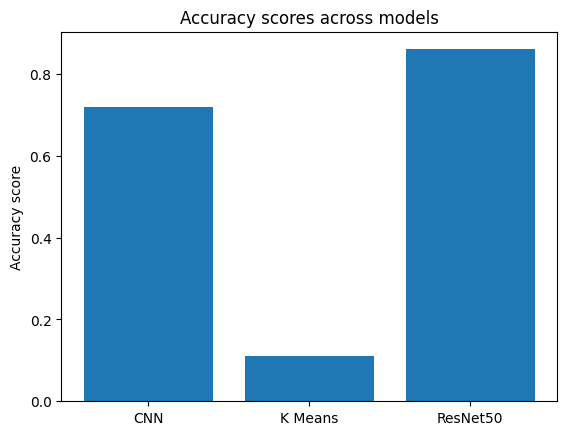

In [525]:
accuracies = [0.72, 0.11, 0.86]
model_names = ["CNN", "K Means", "ResNet50"]

plt.bar(x= model_names, height= accuracies)
plt.title("Accuracy scores across models")
plt.ylabel("Accuracy score")
plt.show()


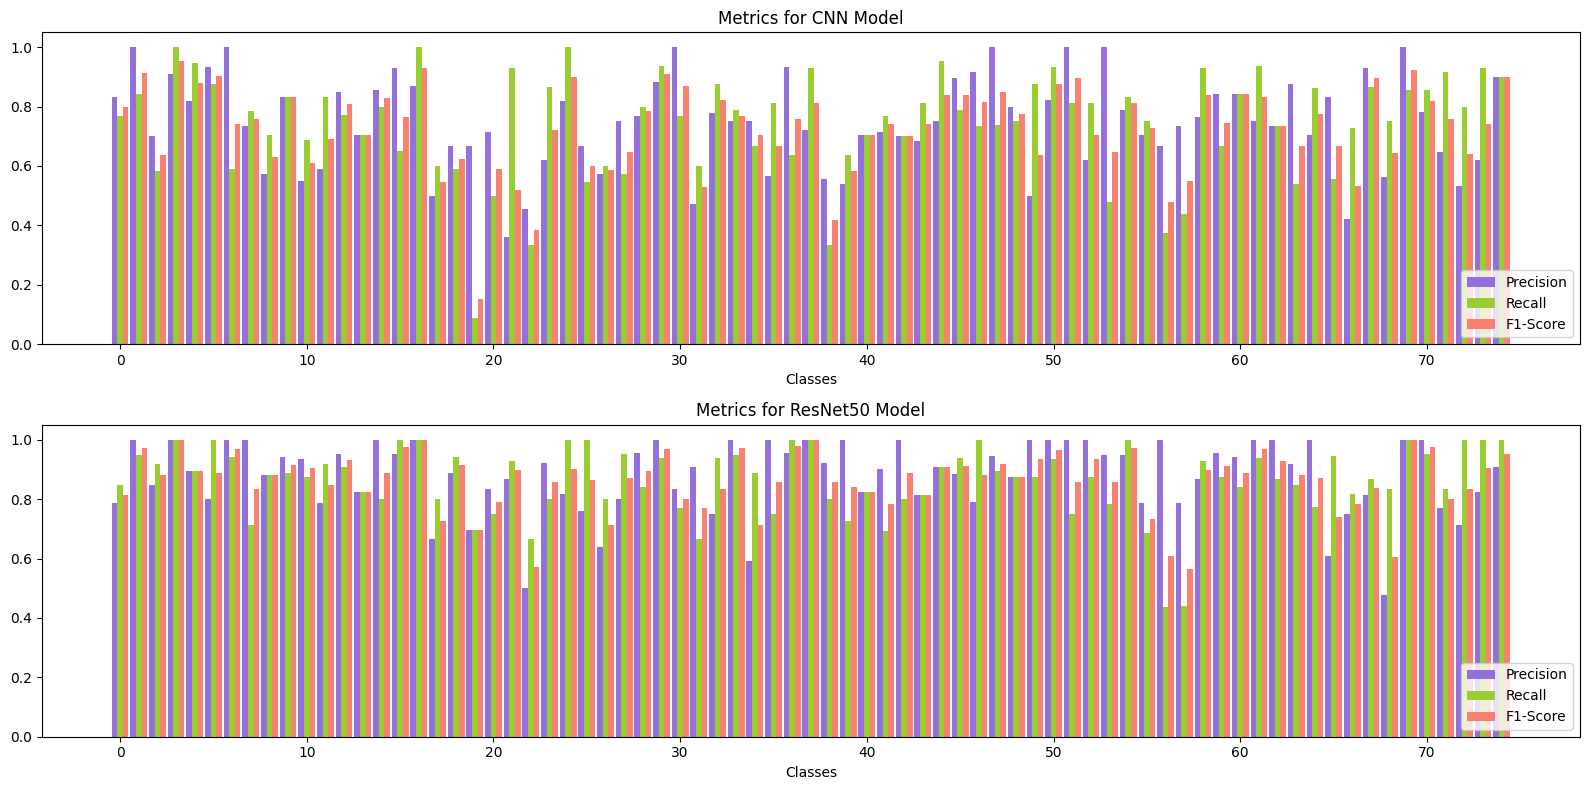

In [520]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

categories_cnn = list(report.keys())[:-3]  #ignore 'accuracy', 'macro avg', 'weighted avg'
precision_cnn = [report[cat]['precision'] for cat in categories_cnn]
recall_cnn = [report[cat]['recall'] for cat in categories_cnn]
f1_score_cnn = [report[cat]['f1-score'] for cat in categories_cnn]

categories_res = list(report_resnet.keys())[:-3]  
precision_res = [report_resnet[cat]['precision'] for cat in categories_res]
recall_res = [report_resnet[cat]['recall'] for cat in categories_res]
f1_score_res = [report_resnet[cat]['f1-score'] for cat in categories_res]

x = np.arange(len(classes)) 
width = 0.3

axes[0].bar(x - width, precision_cnn, width, label='Precision', color='mediumpurple')
axes[0].bar(x, recall_cnn, width, label='Recall', color='yellowgreen')
axes[0].bar(x + width, f1_score_cnn, width, label='F1-Score', color='salmon')

axes[1].bar(x - width, precision_res, width, label='Precision', color='mediumpurple')
axes[1].bar(x, recall_res, width, label='Recall', color='yellowgreen')
axes[1].bar(x + width, f1_score_res, width, label='F1-Score', color='salmon')

axes[0].legend(loc ="lower right")
axes[1].legend(loc = "lower right")
axes[0].set_title("Metrics for CNN Model")
axes[1].set_title("Metrics for ResNet50 Model")
axes[0].set_xlabel("Classes")
axes[1].set_xlabel("Classes")

plt.tight_layout()

## Results and Analysis Summary

The first plot above compares accuracy of the three models. We can see clearly that the ResNet50 model just barely outperformed my first CNN model, and both of these way outperformed the Kmeans. 

The next figure shows summary statistics from the 2 CNNS models. By showing precision, recall, and f1, we can get an accurate picture of the model's performance in multiple aspects. We can see that the first one clearly performed okay across the board with the exception of class 19 (which we investigated earlier). The second one, ResNet50, performed better in the sense that scores are more balanced across classes and generally higher. 

I will summarize more notable model features here:

CNN model: <br>
- 9 layers 
- tested 20 epochs, about 15 seems to be ideal
- test accuracy of 72%
- relatively even performance across classes (precision, recall, f1) with the exception of a few outliers
- minimal misclassification except in seemingly similar species
- training time = about 30 minutes
- hyperparameter tuning: # of neurons in dense layers, # epochs

K Means Clustering model:
- test accuracy of about 11%
- high misclassfication
- poor precision, recall, f1 across all classes
- training time = about 3 minutes 

ResNet50:
- 50+ layers
- tested 10 epochs, about 6-10 seems to be ideal
- test accuracy of about 0.86 in the 10 epoch model
- even and high performance of precision, recall, f1 across all classes 
- very minimal misclassification
- training time = 1 hour + for all 10 epochs
- hyperparameter tuning: # neurons in dense layers, # epochs, # layers to freeze/train


Hyperparameter tuning was a big component to the success of my CNN models. In the first model, I explored the impact of changing # of neurons in the first dense layer (because the second layer had to be 75 to correspond to classes). I observed that more neurons led to better performance. I applied this same theory to the ResNet50 model, but went with a slightly lower value of 256 for the sake of time. I also noticed that more epochs leads to more accuracy, but this levels off at a point, which makes sense considering too much information can lead to overfitting. In the first CNN model that point was at about 15 epochs, in the ResNet50 it was much lower at about 6-10 epochs, likely because there was so much more information in the architecture of this model. Finally, in the ResNet50, I played around with freezing different quantities of training levels. This model took so long to run that I just did this by observing the first few epochs and restarting/making adjustments as necessary. I ended up with leaving about 20% trainable based on online research and my brief observations. Again, given that this is a pretty specific classification problem and this model was trained on a large dataset with lots of variation, it was definitely necessary to retrain some layers to some degree.

Overall, the best performing model was ResNet50. This makes sense considering this model is already trained and I am simply adding on some layers which help it to learn subtle differences in the butterfly classes.


### Conclusion

Overall we see higher accuracy in the CNN models than Kmeans. After some additional reading about KMeans for image classification, I think it would have been better to extract features and then perform clustering, rather than my approach to put the minimally processed pixel values directly in as an array. The CNN models are more successful because they are able to look at the images in different scales. They can detect small feature, mid-sized, features, etc. and make a more detailed evalaution. The downside is that they do take quite long. I think if time was not an issue, I could have achieved even high accuracies by expanding number of layers and layer sizes. 

In the ResNet50 model, I could have attempted to unfreeze more layers. Or I could have added more neurons in the first Dense layer as I did in the previous CNN model. Time would increase but so would performance.

Compared to ResNet50, the fully implemented CNN model ran almost twice as fast. This makes sense because it was considering significantly less data across fewer layers. This likely also explains the 10% difference in performance between the two models. In the first CNN model, I could have considered adding more layers with more neurons. This would have slowed down the model training but would likely improve dataset accuracy and precision, recall, and f1 scores.

All in all, I am happy with how the CNN models performed. This was a great introduction to understanding the architecture and implemenetation of neural networks for an image classification task. It also helped me gain a better understanding of what it means to work with a fully implemented model vs a pretrained model. 

